# Projet Data Mining - Analyse Allociné
## Théo Alves Da Costa

### Sommaire : 
- 1) Chargement et traitement des datasets
- 2) Exploration et première approche
- 3) Classification non-supervisée
- 4) Classification supervisée
- 5) Combinaison des différents classifiers
- 6) Combinaison des différents datasets

In [1]:
#Chargement des librairies utilisées pendant le projet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.style.use('ggplot')
#plt.style.use('fivethirtyeight')
%matplotlib inline

***
### 1. Chargement et traitement des datasets

#### CHARGEMENT

In [2]:
# Changer ici le chemin vers les fichiers pour tester
path = "Centrale/DM2016_Project/DM2016_Project/data/"

In [3]:
train_bi = open(path+"train_bigram.txt","r").read().split("\n")
train_uni = open(path+"train_unigram.txt","r").read().split("\n")
train_unibi = open(path+"train_unigram+bigram.txt","r").read().split("\n")
test_bi = open(path+"test_bigram.txt","r").read().split("\n")
test_uni = open(path+"test_unigram.txt","r").read().split("\n")
test_unibi = open(path+"test_unigram+bigram.txt","r").read().split("\n")

In [4]:
print(len(train_bi))
print(train_bi[0])

3000
1 14:0.1968945584696146 57:0.1931310155053385 68:0.1849318947815893 73:0.1712310249430534 74:0.09667728802234662 81:0.2213387538555783 96:0.1886954377458653 125:0.1696762054432792 133:0.204215633701614 257:0.1867688452301159 271:0.2338431860434315 333:0.2141393653567161 457:0.2101202401820319 463:0.1984432790716003 471:0.1770283496980312 514:0.2057058978700472 533:0.1882049058023192 587:0.1620723338824454 602:0.18339180434326 614:0.1934081205979946 644:0.2076514792362001 651:0.1804808953020789 656:0.1752331626734433 701:0.226773052369155 703:0.2338431860434315 760:0.1646711210866285 774:0.1761205553811566


#### TRAITEMENT
- L'output précédent est une string
- Pour pouvoir exploiter les reviews, on convertit chaque string en un dataframe pandas

In [5]:
def convert_review(review,train = True):
    '''Convertit le string d une review en un dictionnaire de données exploitables'''
    review = review.split(' ')
    new_review = {}
    if train:
        new_review['target'] = review[0]
    new_review['data'] = {}
    for data in review[1:]:
        word,tfidf = data.split(':')
        new_review['data'][int(word)] = float(tfidf)
    return new_review

import itertools

def reviews(train,test,with_tfidf = True):
    '''Convertit un fichier de reviews (train + test) en un dataframe pandas
    contenant les reviews en ligne et les features (tfidf des mots en colonne)
    '''
    #On convertit chaque review en dictionnaire avec la fonction précédente
    train = [convert_review(x) for x in train]
    test = [convert_review(x) for x in test]
    
    train_datas = [x['data'] for x in train]
    train_targets = [x['target'] for x in train]
    test_datas = [x['data'] for x in test]
    
    #On récupère le nombre maximal de features (nombre de mots différents au maximum (voir l'étude ci-dessous))
    max_train =  max([max(list(x.keys())) for x in train_datas])
    max_test = max([max(list(x.keys())) for x in test_datas])
    maximum_features = max(max_train,max_test)
    
    #On crée les listes qui contiendront pour chaque feature un score (tfidf si le mot est présent 0 sinon)
    new_train = []
    new_test = []
    
    #On remplit les listes aux mots correspondants si le tfidf est non nul
    for review in train_datas:
        data = [0]*(maximum_features+1)
        for word,tfidf in review.items():
            if with_tfidf:
                data[word] = tfidf
            else:
                data[word] = 1
        new_train += [data]
        
    for review in test_datas:
        data = [0]*(maximum_features+1)
        for word,tfidf in review.items():
            if with_tfidf:
                data[word] = tfidf
            else:
                data[word] = 1
        new_test += [data]
    
    #On convertit en dataFrame en rajoutant les targets pour le set d'entrainement
    new_targets = pd.DataFrame(train_targets,columns = ['target'])
    new_train,new_test = pd.concat([new_targets,pd.DataFrame(new_train)],axis = 1),pd.DataFrame(new_test)
    
    return new_train,new_test

a,b = reviews(train_uni,test_uni)

***
### 2. Exploration et première approche

#### EXPLORATION D'UN DES DATASETS
On va commencer par explorer un des datasets pour comprendre la teneur des informations

Ici avec le dataset *bigram* 

In [6]:
train,test = reviews(train_bi,test_bi)
X = train.iloc[:,1:]
y = train.iloc[:,0]
z = pd.DataFrame() #contiendra les résultats des différentes approches

In [7]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,812,813,814,815,816,817,818,819,820,821
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.001297,0.003270,0.003727,0.002897,0.002072,0.003581,0.009205,0.00338,0.003274,0.002857,...,0.001979,0.001668,0.002398,0.002001,0.004207,0.001724,0.001723,0.002163,0.004017,0.002204
std,0.017138,0.033325,0.034408,0.031421,0.026597,0.038028,0.056224,0.03983,0.037338,0.030943,...,0.026802,0.028535,0.027045,0.026130,0.034597,0.022983,0.024434,0.026514,0.032773,0.028358
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.360986,0.630162,0.569686,0.587572,0.596276,1.000000,1.000000,1.00000,0.916398,0.487791,...,0.575832,1.000000,0.587532,0.689178,0.708955,0.452310,0.704904,0.549760,0.553449,0.598659


X contient l'ensemble des données pour les 822 éléments tfidf bigram et pour le 3000 reviews

In [8]:
y.describe()

count     3000
unique       2
top         -1
freq      1500
Name: target, dtype: object

y contient bien les résultats +1 pour une review positive, -1 pour une review négative

#### AFFICHAGE
On affiche en lignes les différentes reviews et en colonnes les différents termes et leur score tfidf
Dans le graphique ci-dessous, les données sont triées sur les 30 premiers termes les plus fréquents dans les reviews, projetés sur les 30 premières reviews

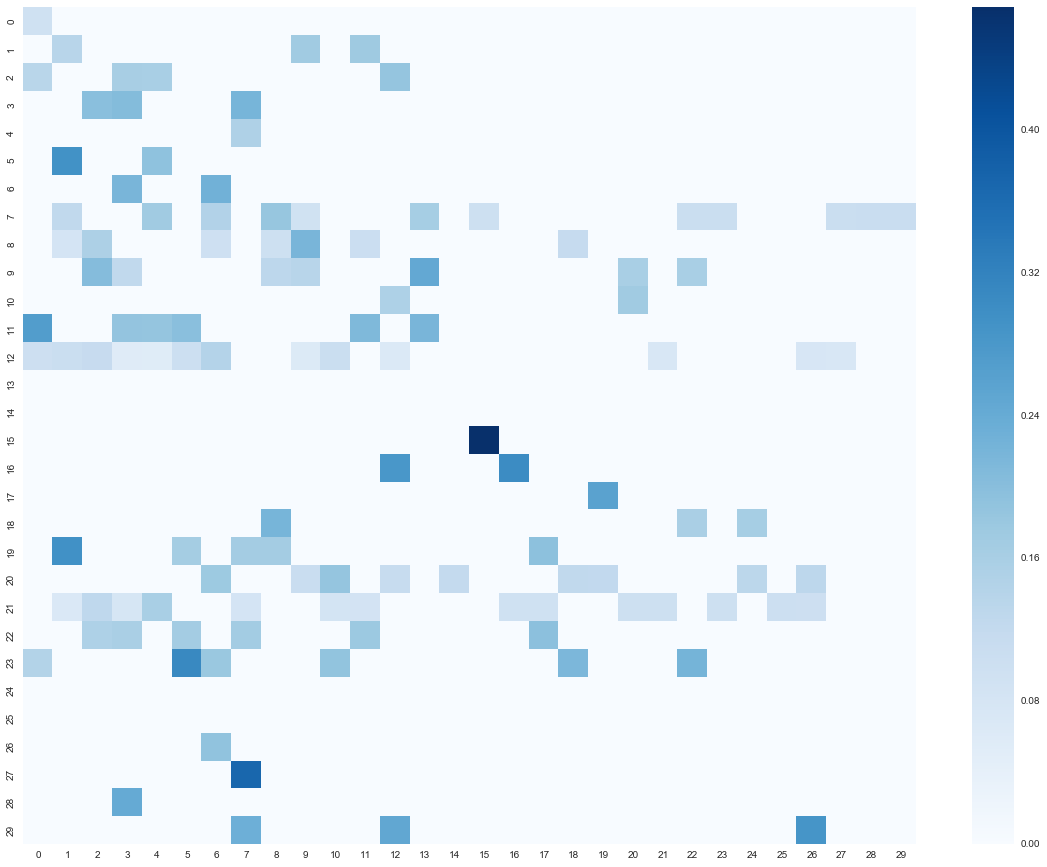

In [9]:
sns.set()
X2 = sorted(X.columns,key = lambda t:len(X[X[t]>0][t]),reverse = True)
X2 = X.reindex_axis(X2,axis = 1)
plt.figure(figsize = (20,15))
ax = sns.heatmap(np.array(X2.iloc[:30,:30]),cmap="Blues")

### 3. Classification non-supervisée
#### CLUSTERING K-MEANS
Une première approche pour explorer le dataset est de réaliser un classification non supervisée par un clustering pour essayer de retrouver les deux clusters : reviews positives et négatives

In [10]:
from sklearn.cluster import KMeans
from sklearn import metrics

name = 'kmeans1'
kmeans_model = KMeans(n_clusters = 2,random_state = 1).fit(X)
labels = kmeans_model.labels_
z[name] = labels
pd.crosstab(labels,y)

target,-1,1
row_0,,
0,1011,1088
1,489,412


On remarque qu'un KMeans simple **ne permet pas** de retrouver les deux clusters

Affichons ce qu'il se passe pour mieux comprendre avec une PCA

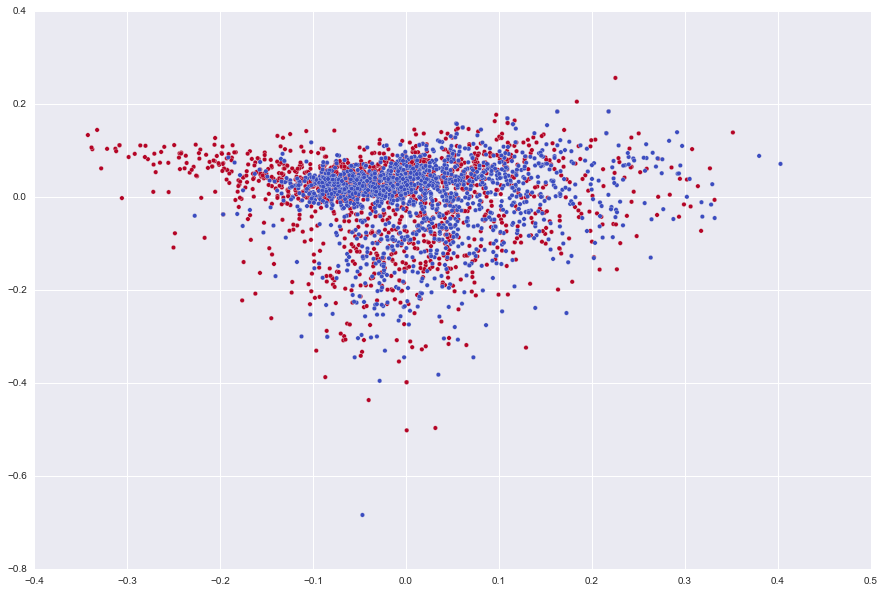

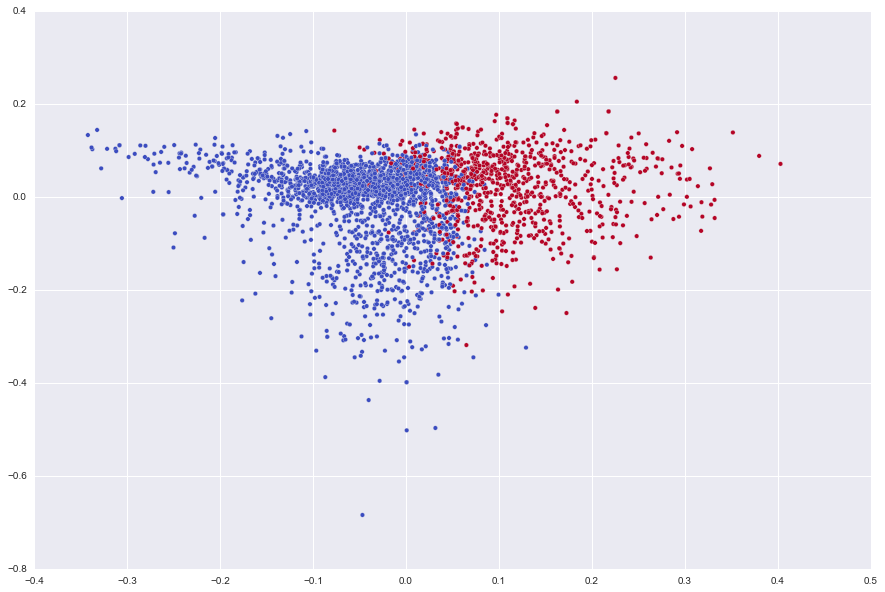

In [11]:
from sklearn.decomposition import PCA
#On utilise la PCA pour afficher les clusters sur un graphique
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(X)
plt.figure(figsize = (15,10))
plt.scatter(x=plot_columns[:,0],y=plot_columns[:,1],c=y,cmap = 'coolwarm')
plt.show()
plt.figure(figsize = (15,10))
plt.scatter(x=plot_columns[:,0],y=plot_columns[:,1],c=z['kmeans1'],cmap = 'coolwarm')
plt.show()

On remarque qu'un clustering KMeans simple n'est pas du tout approprié, basé sur les distances des labels

#### AUTRES ALGORITHMES DE CLUSTERING
##### MiniBatch KMeans

In [12]:
from sklearn.cluster import MiniBatchKMeans
kmeans_model = MiniBatchKMeans(n_clusters = 2,random_state = 1).fit(X)
labels = kmeans_model.labels_
pd.crosstab(labels,y)

target,-1,1
row_0,,
0,902,734
1,598,766


##### Spectral Clustering

In [13]:
from sklearn.cluster import SpectralClustering
kmeans_model = SpectralClustering(n_clusters = 2,random_state = 1).fit(X)
labels = kmeans_model.labels_
pd.crosstab(labels,y)

target,-1,1
row_0,,
0,721,554
1,779,946


Les différents algorithmes de clustering ne permettent pas d'obtenir une séparation intéressante.

Il faut donc passer à une classification supervisée.

***
### 4. Classification supervisée

On va tester différents classifiers pour le moment toujours sur le dataset bigram

Pour cela on va réaliser une fonction qui permet de tester en validation croisée la précision du classifier

In [14]:
from sklearn.svm import LinearSVC
from sklearn.cross_validation import cross_val_score

clf = LinearSVC(C=1)
clf.fit(X,y)

def scores(clf,X,y,title = '',show_scores = True,graph = False,training_score = False):
    if training_score:
        print("Score d'entrainement:",clf.score(X,y))
    scores = list(cross_val_score(clf,X,y,cv = 5))
    scores = sum(scores)/len(scores)
    if show_scores:
        print(title + ' - cross val score : {0}'.format(round(scores,3)))
    else:
        return scores
    if graph:
        Xp = clf.predict(X)
        pca_2 = PCA(2)
        plot_columns = pca_2.fit_transform(X)
        plt.figure(figsize = (15,5))
        plt.scatter(x=plot_columns[:,0],y=plot_columns[:,1],c=Xp)
        plt.title(title)
        plt.show()
    
scores(clf,X,y,'Linear SVM')

Linear SVM - cross val score : 0.745


Ci-dessous les différents classifiers que nous allons utiliser

In [15]:
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#CLASSIFIER
classifiers = [
    ('Naive Bayes Multinomial',naive_bayes.MultinomialNB(fit_prior = True)),
    ('Naive Bayes Gaussian',naive_bayes.GaussianNB()),
    ('Logistic Regression',LogisticRegression()),
    ('Linear SVC',LinearSVC(C=1.0)),
    ('Random Forest',RandomForestClassifier(n_estimators=30,min_samples_leaf = 1,min_samples_split = 10)),
    ('Gradient Boosting',GradientBoostingClassifier(random_state=1, n_estimators=50, max_depth=30)),
    ('KNeighbors',KNeighborsClassifier()),
    ('SVC',SVC(gamma=2, C=1)),
    ('Decision Tree',DecisionTreeClassifier()),
]


#### PREMIERS RESULTATS

In [16]:
for name,clf in classifiers:
    scores(clf,X,y,name)

Naive Bayes Multinomial - cross val score : 0.773
Naive Bayes Gaussian - cross val score : 0.75
Logistic Regression - cross val score : 0.762
Linear SVC - cross val score : 0.745
Random Forest - cross val score : 0.725
Gradient Boosting - cross val score : 0.719
KNeighbors - cross val score : 0.695
SVC - cross val score : 0.756
Decision Tree - cross val score : 0.668


Globalement les meilleurs classifiers en validation croisée sont : 
- Naive Bayes multinomial et gaussien
- SVM
- Logistic Regression

Les meilleurs paramètres des classifiers suivants ont été trouvés par itération ci-dessous : 
- Random Forest
- Gradient Boosting
- Logistic Regression

#### DETERMINATION DES MEILLEURS PARAMETRES POUR CERTAINS CLASSIFIERS
##### Random Forest

In [17]:
#Variation du nombre d'estimateurs
for i in range(10,100,10):
    clf = RandomForestClassifier(n_estimators=i,min_samples_leaf = 5,min_samples_split = 50)
    scores(clf,X,y)

 - cross val score : 0.72
 - cross val score : 0.724
 - cross val score : 0.73
 - cross val score : 0.731
 - cross val score : 0.73
 - cross val score : 0.741
 - cross val score : 0.729
 - cross val score : 0.731
 - cross val score : 0.736


In [18]:
#Variation de min_sample_leaf
for i in range(1,50,5):
    clf = RandomForestClassifier(n_estimators=30,min_samples_leaf = i,min_samples_split = 5)
    scores(clf,X,y)

 - cross val score : 0.729
 - cross val score : 0.732
 - cross val score : 0.711
 - cross val score : 0.695
 - cross val score : 0.674
 - cross val score : 0.661
 - cross val score : 0.639
 - cross val score : 0.629
 - cross val score : 0.616
 - cross val score : 0.581


In [19]:
#Variation de min_sample_leaf
for i in range(5,50,5):
    clf = RandomForestClassifier(n_estimators=30,min_samples_leaf = 5,min_samples_split = i)
    scores(clf,X,y)

 - cross val score : 0.724
 - cross val score : 0.722
 - cross val score : 0.728
 - cross val score : 0.73
 - cross val score : 0.724
 - cross val score : 0.728
 - cross val score : 0.722
 - cross val score : 0.723
 - cross val score : 0.726


Le meilleur paramétrage est ainsi : 
- 30 estimateurs
- 1 feuille au minimum dans l'échantillon
- 10 feuilles pour split

##### Gradient Boosting

In [20]:
#Variation du nombre d'estimateurs
for i in range(10,100,10):
    clf = GradientBoostingClassifier(random_state=1, n_estimators=i, max_depth=10)
    scores(clf,X,y)

 - cross val score : 0.661
 - cross val score : 0.687
 - cross val score : 0.704
 - cross val score : 0.706
 - cross val score : 0.712
 - cross val score : 0.711
 - cross val score : 0.714
 - cross val score : 0.713
 - cross val score : 0.713


In [21]:
#Variation de la profondeur maximale
for i in range(5,50,5):
    clf = GradientBoostingClassifier(random_state=1, n_estimators=50, max_depth=i)
    scores(clf,X,y)

 - cross val score : 0.694
 - cross val score : 0.712
 - cross val score : 0.71
 - cross val score : 0.716
 - cross val score : 0.714
 - cross val score : 0.719
 - cross val score : 0.712
 - cross val score : 0.712
 - cross val score : 0.705


Le meilleur paramétrage est ainsi : 
- 50 estimateurs
- 30 en profondeur

##### Logistic Regression

In [22]:
for C in [10**x for x in range(-3,5)]:
    clf = LogisticRegression(C = C)
    scores(clf,X,y,str(C))

0.001 - cross val score : 0.742
0.01 - cross val score : 0.743
0.1 - cross val score : 0.747
1 - cross val score : 0.762
10 - cross val score : 0.75
100 - cross val score : 0.725
1000 - cross val score : 0.698
10000 - cross val score : 0.693


C = 1 est le meilleur paramétrage

#### PREMIERE CONCLUSION

On peut atteindre une précision d'environ 75% en validation croisée avec les meilleurs classifiers. Ce score peut cependant être optimisé en prenant en compte :
- **une combinaison des différents classifiers**
- **une combinaison des différents datasets**

***
### 5. Combinaison des différents classifiers
Il pourrait être intéressant de combiner les meilleurs classifiers et de prendre la moyenne des résultats

C'est à dire qu'on prédit avec plusieurs classifiers et on prend la moyenne des résultats, cela permet d'annuler les imperfections de certains modèles

Il faut ainsi confectionner un set de test et d'entraînement

In [23]:
from sklearn.cross_validation import train_test_split
X1,X2,y1,y2 = train_test_split(X,y,test_size = 0.3,random_state = None)

In [24]:
#la distribution est assez bien respectée
y1.value_counts()

1     1059
-1    1041
Name: target, dtype: int64

In [25]:
clf = classifiers[0][1] #multinomial
clf.fit(X1,y1)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Pour calculer le score de précision, il faut programmer une fonction qui teste le score apparent

In [26]:
prediction = clf.predict(X2)
print(clf.score(X2,y2))

def precision(prediction,reel):
    score = 0
    for i in range(len(prediction)):
        if prediction[i] == list(reel)[i]:
            score += 1
    return score/len(prediction)

print(precision(prediction,y2))

0.791111111111
0.7911111111111111


On construit le dataset comprenant l'ensemble des prédictions

In [27]:
combinaison = pd.DataFrame()

for name,clf in classifiers:
    clf.fit(X1,y1)
    combinaison[name] = clf.predict(X2)
    print(name," - ",clf.score(X2,y2))

Naive Bayes Multinomial  -  0.791111111111
Naive Bayes Gaussian  -  0.737777777778
Logistic Regression  -  0.78
Linear SVC  -  0.77
Random Forest  -  0.732222222222
Gradient Boosting  -  0.713333333333
KNeighbors  -  0.667777777778
SVC  -  0.771111111111
Decision Tree  -  0.671111111111


In [28]:
combinaison.head()

,Naive Bayes Multinomial,Naive Bayes Gaussian,Logistic Regression,Linear SVC,Random Forest,Gradient Boosting,KNeighbors,SVC,Decision Tree
0,1,1,1,1,1,1,1,1,1
1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,-1,-1,-1,-1,-1,1
3,1,1,1,1,1,1,1,1,-1
4,-1,-1,-1,-1,1,-1,-1,-1,1


On va moyenner sur le tableau de résultat pour tenter d'obtenir de meilleurs résultats

In [29]:
# Moyenne de toutes les colonnes
moyennes = []
nb_columns = len(combinaison.columns)
for i in combinaison.index: #range(len(combinaison)):
    moyenne = sum([int(combinaison.iloc[i,j]) for j in range(nb_columns)])
    moyenne = 1 if moyenne > 0 else -1
    moyennes += [str(moyenne)]
combinaison['Total Average'] = moyennes

# Moyenne des meilleurs critères
moyennes = []
sel_columns = ['Naive Bayes Multinomial','Naive Bayes Gaussian','Logistic Regression','Linear SVC','SVC']
# il est important de prendre un nombre impair pour ne pas introduire le biais du choix si le resultat est positif
for i in combinaison.index: #range(len(combinaison)):
    moyenne = sum([int(combinaison.loc[i,column]) for column in sel_columns])
    moyenne = 1 if moyenne > 0 else -1
    moyennes += [str(moyenne)]
combinaison['Best Average'] = moyennes

In [30]:
for column in combinaison.columns:
    print(column," - ",precision(combinaison[column],y2))

Naive Bayes Multinomial  -  0.7911111111111111
Naive Bayes Gaussian  -  0.7377777777777778
Logistic Regression  -  0.78
Linear SVC  -  0.77
Random Forest  -  0.7322222222222222
Gradient Boosting  -  0.7133333333333334
KNeighbors  -  0.6677777777777778
SVC  -  0.7711111111111111
Decision Tree  -  0.6711111111111111
Total Average  -  0.7888888888888889
Best Average  -  0.7844444444444445


##### Le moyennage n'arrive pas à compenser les erreurs des classifiers sur ce dataset

***
### 6. Comparaison des résultats sur les différents datasets
- Certains mots doivent mieux fonctionner en unigram, ex : mauvais
- Cependant ils peuvent avoir un sens différent en bigram, ex : pas mauvais

En somme la comparaison des 3 différents modèles sur les classifiers peut être intéressante. Par la suite il sera peut être avisé de combiner les résultats sur les différents datasets, comme réalisé au dessus pour les classifiers

In [31]:
results = {}
for train,test,title in (train_bi,test_bi,"Bigram"),(train_uni,test_uni,"Unigram"),(train_unibi,test_unibi,"Unigram + Bigram"):
    print(' - ',title,' - ')
    train,test = reviews(train,test)
    X = train.iloc[:,1:]
    y = train.iloc[:,0]
    all_scores = []
    indexes = []
    for name,clf in classifiers:
        print(name)
        indexes += [name]
        all_scores += [scores(clf,X,y,name,False)]
    results[title] = all_scores

 -  Bigram  - 
Naive Bayes Multinomial
Naive Bayes Gaussian
Logistic Regression
Linear SVC
Random Forest
Gradient Boosting
KNeighbors
SVC
Decision Tree
 -  Unigram  - 
Naive Bayes Multinomial
Naive Bayes Gaussian
Logistic Regression
Linear SVC
Random Forest
Gradient Boosting
KNeighbors
SVC
Decision Tree
 -  Unigram + Bigram  - 
Naive Bayes Multinomial
Naive Bayes Gaussian
Logistic Regression
Linear SVC
Random Forest
Gradient Boosting
KNeighbors
SVC
Decision Tree


In [32]:
resultsdf = pd.DataFrame(results,index = indexes)
resultsdf

,Bigram,Unigram,Unigram + Bigram
Naive Bayes Multinomial,0.773333,0.861333,0.864667
Naive Bayes Gaussian,0.750333,0.782333,0.810333
Logistic Regression,0.762000,0.862667,0.869333
Linear SVC,0.745000,0.849333,0.858333
Random Forest,0.727667,0.797667,0.815667
Gradient Boosting,0.718667,0.765000,0.771000
KNeighbors,0.694667,0.761667,0.760333
SVC,0.755667,0.857333,0.856667
Decision Tree,0.667000,0.690667,0.681000


Le meilleur classifier est **Logistic Regression sur Unigram + Bigram**

De nouvelles améliorations viennent à l'idée : 
- Analyser les meilleurs features, quels mots permettent vraiment de classifier
- Combiner les différents datasets et les différents classifiers

### 7. Analyse des best features

In [33]:
clf = LogisticRegression(C=1)

features = list(X.columns)
features_scores = []
for feature in features:
    if feature%100 == 0:
        print("100 features done")
    features_scores += [[feature,scores(clf,X[[feature]],y,show_scores = False)]]


100 features done
100 features done
100 features done
100 features done
100 features done
100 features done
100 features done
100 features done
100 features done
100 features done
100 features done
100 features done
100 features done
100 features done
100 features done
100 features done
100 features done
100 features done
100 features done


On regarde quels sont les termes qui, seuls, amènent la meilleure précision

In [34]:
pd.DataFrame(sorted(features_scores,key = lambda t:t[1],reverse = True),columns = ['feature','score']).iloc[:10,:]

,feature,score
0,1176,0.600667
1,1437,0.580000
2,1078,0.575333
3,523,0.571667
4,1732,0.569667
5,664,0.568667
6,1475,0.558667
7,1118,0.558000
8,988,0.557667
9,1490,0.549667


Et la pire précision

In [35]:
pd.DataFrame(sorted(features_scores,key = lambda t:t[1],reverse = False),columns = ['feature','score']).iloc[:10,:]

,feature,score
0,504,0.460667
1,1663,0.474667
2,759,0.475333
3,496,0.476000
4,1534,0.476333
5,638,0.478000
6,1448,0.478000
7,527,0.479333
8,973,0.479333
9,33,0.480667


Les résultats ne sont pas intéressants : les valeurs extrêmes sont 46% à 54% de précision

Essayons avec le dataset unigram

In [36]:
train,test = reviews(train_uni,test_uni)
X = train.iloc[:,1:]
y = train.iloc[:,0]
clf = LogisticRegression(C=1)

features = list(X.columns)
features_scores = []
for feature in features:
    if feature%100 == 0:
        print("100 features done")
    features_scores += [[feature,scores(clf,X[[feature]],y,show_scores = False)]]

100 features done
100 features done
100 features done
100 features done
100 features done
100 features done
100 features done
100 features done
100 features done
100 features done


In [37]:
pd.DataFrame(sorted(features_scores,key = lambda t:t[1],reverse = True),columns = ['feature','score']).iloc[:10,:]

,feature,score
0,600,0.599333
1,752,0.580000
2,556,0.576000
3,345,0.575000
4,295,0.571667
5,934,0.569667
6,782,0.558667
7,577,0.558000
8,491,0.557667
9,790,0.549667


In [38]:
pd.DataFrame(sorted(features_scores,key = lambda t:t[1],reverse = False),columns = ['feature','score']).iloc[:10,:]

,feature,score
0,289,0.461000
1,397,0.468667
2,283,0.476000
3,761,0.478000
4,297,0.479333
5,23,0.480667
6,439,0.482333
7,728,0.483667
8,171,0.484000
9,578,0.484000


Les features ne sont pas assez différenciants pour faire une sélection, 
Je n'irai pas plus loin dans cette approche

***
### 8. Combinaison des 3 datasets avec les meilleurs prédicteurs

##### Combinaison des 3 datasets avec le même classifier : "Logistic Regression"

In [39]:
trains,tests = {},{}
for train,test,name in (train_uni,test_uni,'unigram'),(train_bi,test_bi,'bigram'),(train_unibi,test_unibi,'unibigram'):
    trains[name],tests[name] = reviews(train,test)
    
X,y = {},{}

for name in ('unigram','bigram','unibigram'):
    X[name] = trains[name].iloc[:,1:]
    y[name] = trains[name].iloc[:,0]

In [40]:
#Vérification que les 3 datasets correspondent
names = ('unigram','bigram','unibigram')
print((y['unigram'] == y['bigram']).value_counts())
print('')
print((y['unigram'] == y['unibigram']).value_counts())

True    3000
Name: target, dtype: int64

True    3000
Name: target, dtype: int64


Pour pouvoir faire un test réel il va falloir réaliser un split random identique sur les 3 datasets d'entraînement
Ceci est réalisable en utilisant la fonction train_test_split() avec un random seed identique et défini

In [41]:
X1,X2,y1,y2 = {},{},{},{}

for name in names:
    X1[name],X2[name],y1[name],y2[name] = train_test_split(X[name],y[name],test_size = 0.3,random_state = 1)

In [42]:
#vérification que les index correspondent
print(pd.Series((X1['unigram'].index == X1['bigram'].index)).value_counts())
print('')
print(pd.Series((X1['unigram'].index == X1['unibigram'].index)).value_counts())

True    2100
dtype: int64

True    2100
dtype: int64


On peut à présent réaliser des tests sur les 3 datasets séparément et les joindre par la suite

In [43]:
clf = LogisticRegression(C=1)
all_predictions = pd.DataFrame()
for name in names:
    clf.fit(X1[name],y1[name]) 
    all_predictions[name] = clf.predict(X2[name])

In [44]:
all_predictions.iloc[:10,:]

,unigram,bigram,unibigram
0,-1,-1,-1
1,-1,-1,-1
2,1,1,1
3,-1,-1,-1
4,1,1,1
5,1,1,1
6,1,-1,1
7,1,1,1
8,1,-1,1
9,-1,1,-1


In [45]:
# Moyenne de toutes les colonnes
moyennes = []
nb_columns = len(all_predictions.columns)
for i in all_predictions.index: #range(len(combinaison)):
    moyenne = sum([int(all_predictions.iloc[i,j]) for j in range(nb_columns)])
    moyenne = 1 if moyenne > 0 else -1
    moyennes += [str(moyenne)]
all_predictions['Total Average'] = moyennes
all_predictions.iloc[:10,:]

,unigram,bigram,unibigram,Total Average
0,-1,-1,-1,-1
1,-1,-1,-1,-1
2,1,1,1,1
3,-1,-1,-1,-1
4,1,1,1,1
5,1,1,1,1
6,1,-1,1,1
7,1,1,1,1
8,1,-1,1,1
9,-1,1,-1,-1


In [46]:
for column in all_predictions.columns:
    print(column," - ",precision(all_predictions[column],y2['unigram']))

unigram  -  0.88
bigram  -  0.7655555555555555
unibigram  -  0.89
Total Average  -  0.9


Moyenner sur les 3 datasets permet bien ainsi d'augmenter la précision moyenne

#### Combinaison des 3 datasets avec les meilleurs classifiers dans chaque catégorie

In [47]:
clfs = {}
clfs['bigram'] = naive_bayes.MultinomialNB(fit_prior = True)
clfs['unigram'] = LogisticRegression(C=1)
clfs['unibigram'] = LogisticRegression(C=1)

all_predictions = pd.DataFrame()

for name in names:
    clf = clfs[name] 
    clf.fit(X1[name],y1[name]) 
    all_predictions[name] = clf.predict(X2[name])
    
# Moyenne de toutes les colonnes
moyennes = []
nb_columns = len(all_predictions.columns)
for i in all_predictions.index: #range(len(combinaison)):
    moyenne = sum([int(all_predictions.iloc[i,j]) for j in range(nb_columns)])
    moyenne = 1 if moyenne > 0 else -1
    moyennes += [str(moyenne)]
all_predictions['Total Average'] = moyennes

for column in all_predictions.columns:
    print(column," - ",precision(all_predictions[column],y2['unigram']))

unigram  -  0.88
bigram  -  0.7888888888888889
unibigram  -  0.89
Total Average  -  0.9011111111111111


#### Combinaisons des 3 datasets avec une combinaison des 3 meilleurs classifiers
- Naive Bayes Multinomial
- Logistic Regression
- SVC

In [48]:
clfs = [classifiers[i] for i in [0,2,7]] #correspont aux 3 classifiers présentés ci-dessus

all_predictions = pd.DataFrame()

for name in names:
    for name_clf,clf in clfs:
        clf.fit(X1[name],y1[name])
        all_predictions[name+" - "+name_clf] = clf.predict(X2[name])

In [49]:
all_predictions.head()

,unigram - Naive Bayes Multinomial,unigram - Logistic Regression,unigram - SVC,bigram - Naive Bayes Multinomial,bigram - Logistic Regression,bigram - SVC,unibigram - Naive Bayes Multinomial,unibigram - Logistic Regression,unibigram - SVC
0,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,1,1,1,1,1,1,1,1,1
3,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,1,1,1,1,1,1,1,1,1


In [50]:
all_predictions.describe()

,unigram - Naive Bayes Multinomial,unigram - Logistic Regression,unigram - SVC,bigram - Naive Bayes Multinomial,bigram - Logistic Regression,bigram - SVC,unibigram - Naive Bayes Multinomial,unibigram - Logistic Regression,unibigram - SVC
count,900,900,900,900,900,900,900,900,900
unique,2,2,2,2,2,2,2,2,2
top,1,1,1,-1,-1,-1,1,1,-1
freq,462,461,459,461,464,467,455,462,454


In [51]:
# Moyenne de toutes les colonnes
moyennes = []
nb_columns = len(all_predictions.columns)
for i in all_predictions.index: #range(len(combinaison)):
    moyenne = sum([int(all_predictions.iloc[i,j]) for j in range(nb_columns)])
    moyenne = 1 if moyenne > 0 else -1
    moyennes += [str(moyenne)]
all_predictions['Total Average'] = moyennes

for column in all_predictions.columns:
    print(column," - ",precision(all_predictions[column],y2['unigram']))

unigram - Naive Bayes Multinomial  -  0.8855555555555555
unigram - Logistic Regression  -  0.88
unigram - SVC  -  0.8822222222222222
bigram - Naive Bayes Multinomial  -  0.7888888888888889
bigram - Logistic Regression  -  0.7655555555555555
bigram - SVC  -  0.7711111111111111
unibigram - Naive Bayes Multinomial  -  0.8888888888888888
unibigram - Logistic Regression  -  0.89
unibigram - SVC  -  0.8811111111111111
Total Average  -  0.9022222222222223


#### Combinaisons des 3 datasets avec une combinaison des 5 meilleurs classifiers
- Naive Bayes Multinomial
- Naive Bayes Gaussian
- Logistic Regression
- SVC
- Linear SVC

In [52]:
clfs = [classifiers[i] for i in [0,1,2,3,7]] #correspont aux 5 classifiers présentés ci-dessus

all_predictions = pd.DataFrame()

for name in names:
    for name_clf,clf in clfs:
        clf.fit(X1[name],y1[name])
        all_predictions[name+" - "+name_clf] = clf.predict(X2[name])

In [53]:
all_predictions.describe()

,unigram - Naive Bayes Multinomial,unigram - Naive Bayes Gaussian,unigram - Logistic Regression,unigram - Linear SVC,unigram - SVC,bigram - Naive Bayes Multinomial,bigram - Naive Bayes Gaussian,bigram - Logistic Regression,bigram - Linear SVC,bigram - SVC,unibigram - Naive Bayes Multinomial,unibigram - Naive Bayes Gaussian,unibigram - Logistic Regression,unibigram - Linear SVC,unibigram - SVC
count,900,900,900,900,900,900,900,900,900,900,900,900,900,900,900
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,1,1,1,1,1,-1,1,-1,-1,-1,1,-1,1,1,-1
freq,462,457,461,459,459,461,454,464,457,467,455,455,462,466,454


In [54]:
# Moyenne de toutes les colonnes
moyennes = []
nb_columns = len(all_predictions.columns)
for i in all_predictions.index: #range(len(combinaison)):
    moyenne = sum([int(all_predictions.iloc[i,j]) for j in range(nb_columns)])
    moyenne = 1 if moyenne > 0 else -1
    moyennes += [str(moyenne)]
all_predictions['Total Average'] = moyennes

for column in all_predictions.columns:
    print(column," - ",precision(all_predictions[column],y2['unigram']))

unigram - Naive Bayes Multinomial  -  0.8855555555555555
unigram - Naive Bayes Gaussian  -  0.82
unigram - Logistic Regression  -  0.88
unigram - Linear SVC  -  0.8911111111111111
unigram - SVC  -  0.8822222222222222
bigram - Naive Bayes Multinomial  -  0.7888888888888889
bigram - Naive Bayes Gaussian  -  0.7477777777777778
bigram - Logistic Regression  -  0.7655555555555555
bigram - Linear SVC  -  0.7711111111111111
bigram - SVC  -  0.7711111111111111
unibigram - Naive Bayes Multinomial  -  0.8888888888888888
unibigram - Naive Bayes Gaussian  -  0.8444444444444444
unibigram - Logistic Regression  -  0.89
unibigram - Linear SVC  -  0.8877777777777778
unibigram - SVC  -  0.8811111111111111
Total Average  -  0.9133333333333333


#### Combinaisons des 3 datasets avec une combinaison de tous les classifiers

In [55]:
clfs = classifiers

all_predictions = pd.DataFrame()

for name in names:
    for name_clf,clf in clfs:
        clf.fit(X1[name],y1[name])
        all_predictions[name+" - "+name_clf] = clf.predict(X2[name])

In [56]:
# Moyenne de toutes les colonnes
moyennes = []
nb_columns = len(all_predictions.columns)
for i in all_predictions.index: #range(len(combinaison)):
    moyenne = sum([int(all_predictions.iloc[i,j]) for j in range(nb_columns)])
    moyenne = 1 if moyenne > 0 else -1
    moyennes += [str(moyenne)]
all_predictions['Total Average'] = moyennes

for column in all_predictions.columns:
    print(column," - ",precision(all_predictions[column],y2['unigram']))

unigram - Naive Bayes Multinomial  -  0.8855555555555555
unigram - Naive Bayes Gaussian  -  0.82
unigram - Logistic Regression  -  0.88
unigram - Linear SVC  -  0.8911111111111111
unigram - Random Forest  -  0.8222222222222222
unigram - Gradient Boosting  -  0.7855555555555556
unigram - KNeighbors  -  0.8133333333333334
unigram - SVC  -  0.8822222222222222
unigram - Decision Tree  -  0.74
bigram - Naive Bayes Multinomial  -  0.7888888888888889
bigram - Naive Bayes Gaussian  -  0.7477777777777778
bigram - Logistic Regression  -  0.7655555555555555
bigram - Linear SVC  -  0.7711111111111111
bigram - Random Forest  -  0.7455555555555555
bigram - Gradient Boosting  -  0.7466666666666667
bigram - KNeighbors  -  0.6988888888888889
bigram - SVC  -  0.7711111111111111
bigram - Decision Tree  -  0.6822222222222222
unibigram - Naive Bayes Multinomial  -  0.8888888888888888
unibigram - Naive Bayes Gaussian  -  0.8444444444444444
unibigram - Logistic Regression  -  0.89
unibigram - Linear SVC  -  

La meilleure configuration apparait donc être 
- **analyse sur l'ensemble des 3 datasets**
- **utiliser les 5 meilleurs classfiers au global**

Avec les 15 résultats, on moyenne l'analyse pour chaque prédiction

***
# Prédiction

In [57]:
clfs = [classifiers[i] for i in [0,1,2,3,7]] #correspont aux 5 classifiers présentés ci-dessus

all_predictions = pd.DataFrame()

for name in names:
    for name_clf,clf in clfs:
        clf.fit(X[name],y[name])
        all_predictions[name+" - "+name_clf] = clf.predict(tests[name])

In [58]:
# Moyenne de toutes les colonnes
moyennes = []
nb_columns = len(all_predictions.columns)
for i in all_predictions.index: #range(len(combinaison)):
    moyenne = sum([int(all_predictions.iloc[i,j]) for j in range(nb_columns)])
    moyenne = 1 if moyenne > 0 else -1
    moyennes += [str(moyenne)]
all_predictions['Total Average'] = moyennes
all_predictions.describe()

,unigram - Naive Bayes Multinomial,unigram - Naive Bayes Gaussian,unigram - Logistic Regression,unigram - Linear SVC,unigram - SVC,bigram - Naive Bayes Multinomial,bigram - Naive Bayes Gaussian,bigram - Logistic Regression,bigram - Linear SVC,bigram - SVC,unibigram - Naive Bayes Multinomial,unibigram - Naive Bayes Gaussian,unibigram - Logistic Regression,unibigram - Linear SVC,unibigram - SVC,Total Average
count,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
freq,1352,1414,1376,1396,1364,1302,1396,1333,1358,1304,1341,1398,1369,1389,1358,1370


In [59]:
final_prediction = all_predictions['Total Average']

with open("Centrale/DM2016_Project/submission.txt", 'w') as f_out:
    f_out.write("\n".join(str(int(x)) for x in final_prediction))